LDA on vertebrates
===============

Notes on the data
----------------------

 1. In this example the tree is contstrained
 2. In this example we have to extract position,transition, and branch. 
 3. The total position are broken into N 'splits'                      
 4. Each split contains 30,000 files (except the last file that has less)
 5. So that means that there are 30,000 * N total positions

Browsing the data
----------------------

In [34]:
import os
import numpy as np
from vertebratesLib import *

In [39]:
split = "SPLIT1"
summaryTree,summarySpecies,splitPositions = get_split_data(split)
print summaryTree.shape



(30000, 400)


a sentence of words is represented as the transitions for a given position

In [36]:
def get_sentence(position,splitPositions,summary,ignore=False):
    splitIndex = np.where(splitPositions==position)[0]
    nonZero = np.where(summary[splitIndex,:] != 0)[1]
    sentence = []
    for nz in nonZero:
        if ignore and TRANSITIONS[nz].count(TRANSITIONS[nz][0]) == 2:
            continue
        
        count = int(summary[splitIndex,nz][0])
        sentence.extend([TRANSITIONS[nz]] * count)
    
    return sentence
        
position = '8500'
sentence1 = get_sentence(position,splitPositions,summaryTree,ignore=False)
sentence2 = get_sentence(position,splitPositions,summaryTree,ignore=True)
print("with same AA transition")
print(sentence1)
print("without same AA transition")
print(sentence2)

with same AA transition
['AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AA', 'AL', 'AV', 'FF', 'FF', 'FF', 'FF', 'GG', 'II', 'II', 'LA', 'LA', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'LV', 'LV', 'MM', 'TT', 'TT', 'TT', 'TT', 'TT', 'VA', 'VA', 'VF', 'VI', 'VL', 'VL', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV', 'VV

Simple test run with lda package
----------------------------------------------------


In [37]:
import lda

## the data matrix are the sentences by vocabulary

vocab = TRANSITIONS

#inPlaceTransitions = []
#for t in TRANSITIONS:




Recall that the Dirichlet Process (DP) (Ferguson, 1973) is essentially a distribution over distributions, where each draw from a DP is itself a distribution and importantly for clustering applications it serves as a natural prior that lets the number of clusters grow as the data grows.  The DP has a base distribution parameter $\beta$ and a strength or concentration parameter $\alpha$.   

* $\alpha$ is a hyperprior for the DP over per-document topic distributions
* $\beta$ is the hyperprior for the DP over per-topic word distributions
* $\theta_{m}$ is the topic distribution for document $m$
* $\phi_{k}$ is the word distribution for topic $k$
* $z_{m,n}$ is the topic for the $n$th word in document $m$
* $w_{m,n}$ is the specific word 

The generative story for phylogenetics
--------------------------------------------------------

We are still modeling topics. However, **documents become sites** and **words become transitions**.  Transitions may defined in nucleotide, amino acid or codon space.  Perhaps more logically though a document would be all of the sites for a given gene.

  * $\alpha$ is a hyperprior for the DP over per-site topic distributions
  * $\beta$ is the hyperprior for the DP over per-topic transition distributions
  * $\theta_{m}$ is the topic distribution for gene $m$
  * $\phi_{k}$ is the nucleotide transition distribution for topic $k$
  * $z_{m,n}$ is the topic for the $n$th nucleotide transition in gene $m$
  * $w_{m,n}$ is the specific transition

The generative process
--------------------------------------

  1. Choose $\theta_{m} \sim \textrm{Dir}(\alpha)$, where $m \in \{1,...M\}$ and $\textrm{Dir}(\alpha)$ is the Dirichlet distribtion for $\alpha$
  2. Choose $\phi_{k} \sim \textrm{Dir}(\beta)$, where $k \in \{1,...K\}$
  3. For each of the transition positions ($m$,$n$), where $n \in \{1,...N\}$, and $m \in \{1,...M\}$  
  
     * Choose a topic $z_{m,n} \sim \textrm{Multinomial}(\theta_{m})$
     * Choose a transition $w_{m,n} \sim \textrm{Multinomial}(\phi_{m,n})$
     
$\phi$ is a $K*V$ Markov matrix each row of which denotes the transition distribution of a topic.

The type of data to expect
--------------------------------

Here I am borrowing from the package LDA, which uses a collapsed version of Gibbs sampling.

In this example.

  * Positions are documents
  * First 1000 positions
  * We consider in place transitions
  * 20 topics
  * 1500 MCMC iterations
  * 7 words in a topic (transitions)
  
topics
  
  * Topic 0: EE ED EQ EK EG DE EA
  * Topic 1: YY YF FY FF YH YC YS
  * Topic 2: RR KK RK QQ RQ HH KR
  * Topic 3: AA AS AT AV SS VA SA
  * Topic 4: II MM IV IL IM MI ML
  * Topic 5: SS ST SA SN SP TT SG
  * Topic 6: WW WL YW WS SW WV WG
  * Topic 7: KK KR RR KQ RK KE KN
  * Topic 8: HH HY HQ HR HN QH YH
  * Topic 9: CC CS SC CY SS CF LC
  * Topic 10: VV VI IV VA VL II VM
  * Topic 11: TT TA TS TV TI ST TM
  * Topic 12: DD DE DN ED EE DG ND
  * Topic 13: QQ QK QE QH QR QL QP
  * Topic 14: FF FL LF FY FI FV FC
  * Topic 15: PP PS SP PA PL PT PQ
  * Topic 16: NN NS SS ND NK SN NT
  * Topic 17: LL LI LV LM LF MM LQ
  * Topic 18: RR RK RQ RT RW RY RV
  * Topic 19: GG GS GA GE GN SG GD

top topics

  * position - 0 (top topic: 3)
  * position - 1 (top topic: 19)
  * position - 10 (top topic: 3)
  * position - 100 (top topic: 18)
  * position - 1000 (top topic: 7)
  * position - 10000 (top topic: 7)
  * position - 10001 (top topic: 7)
  * position - 10002 (top topic: 19)
  * position - 10003 (top topic: 7)
  * position - 10004 (top topic: 5)



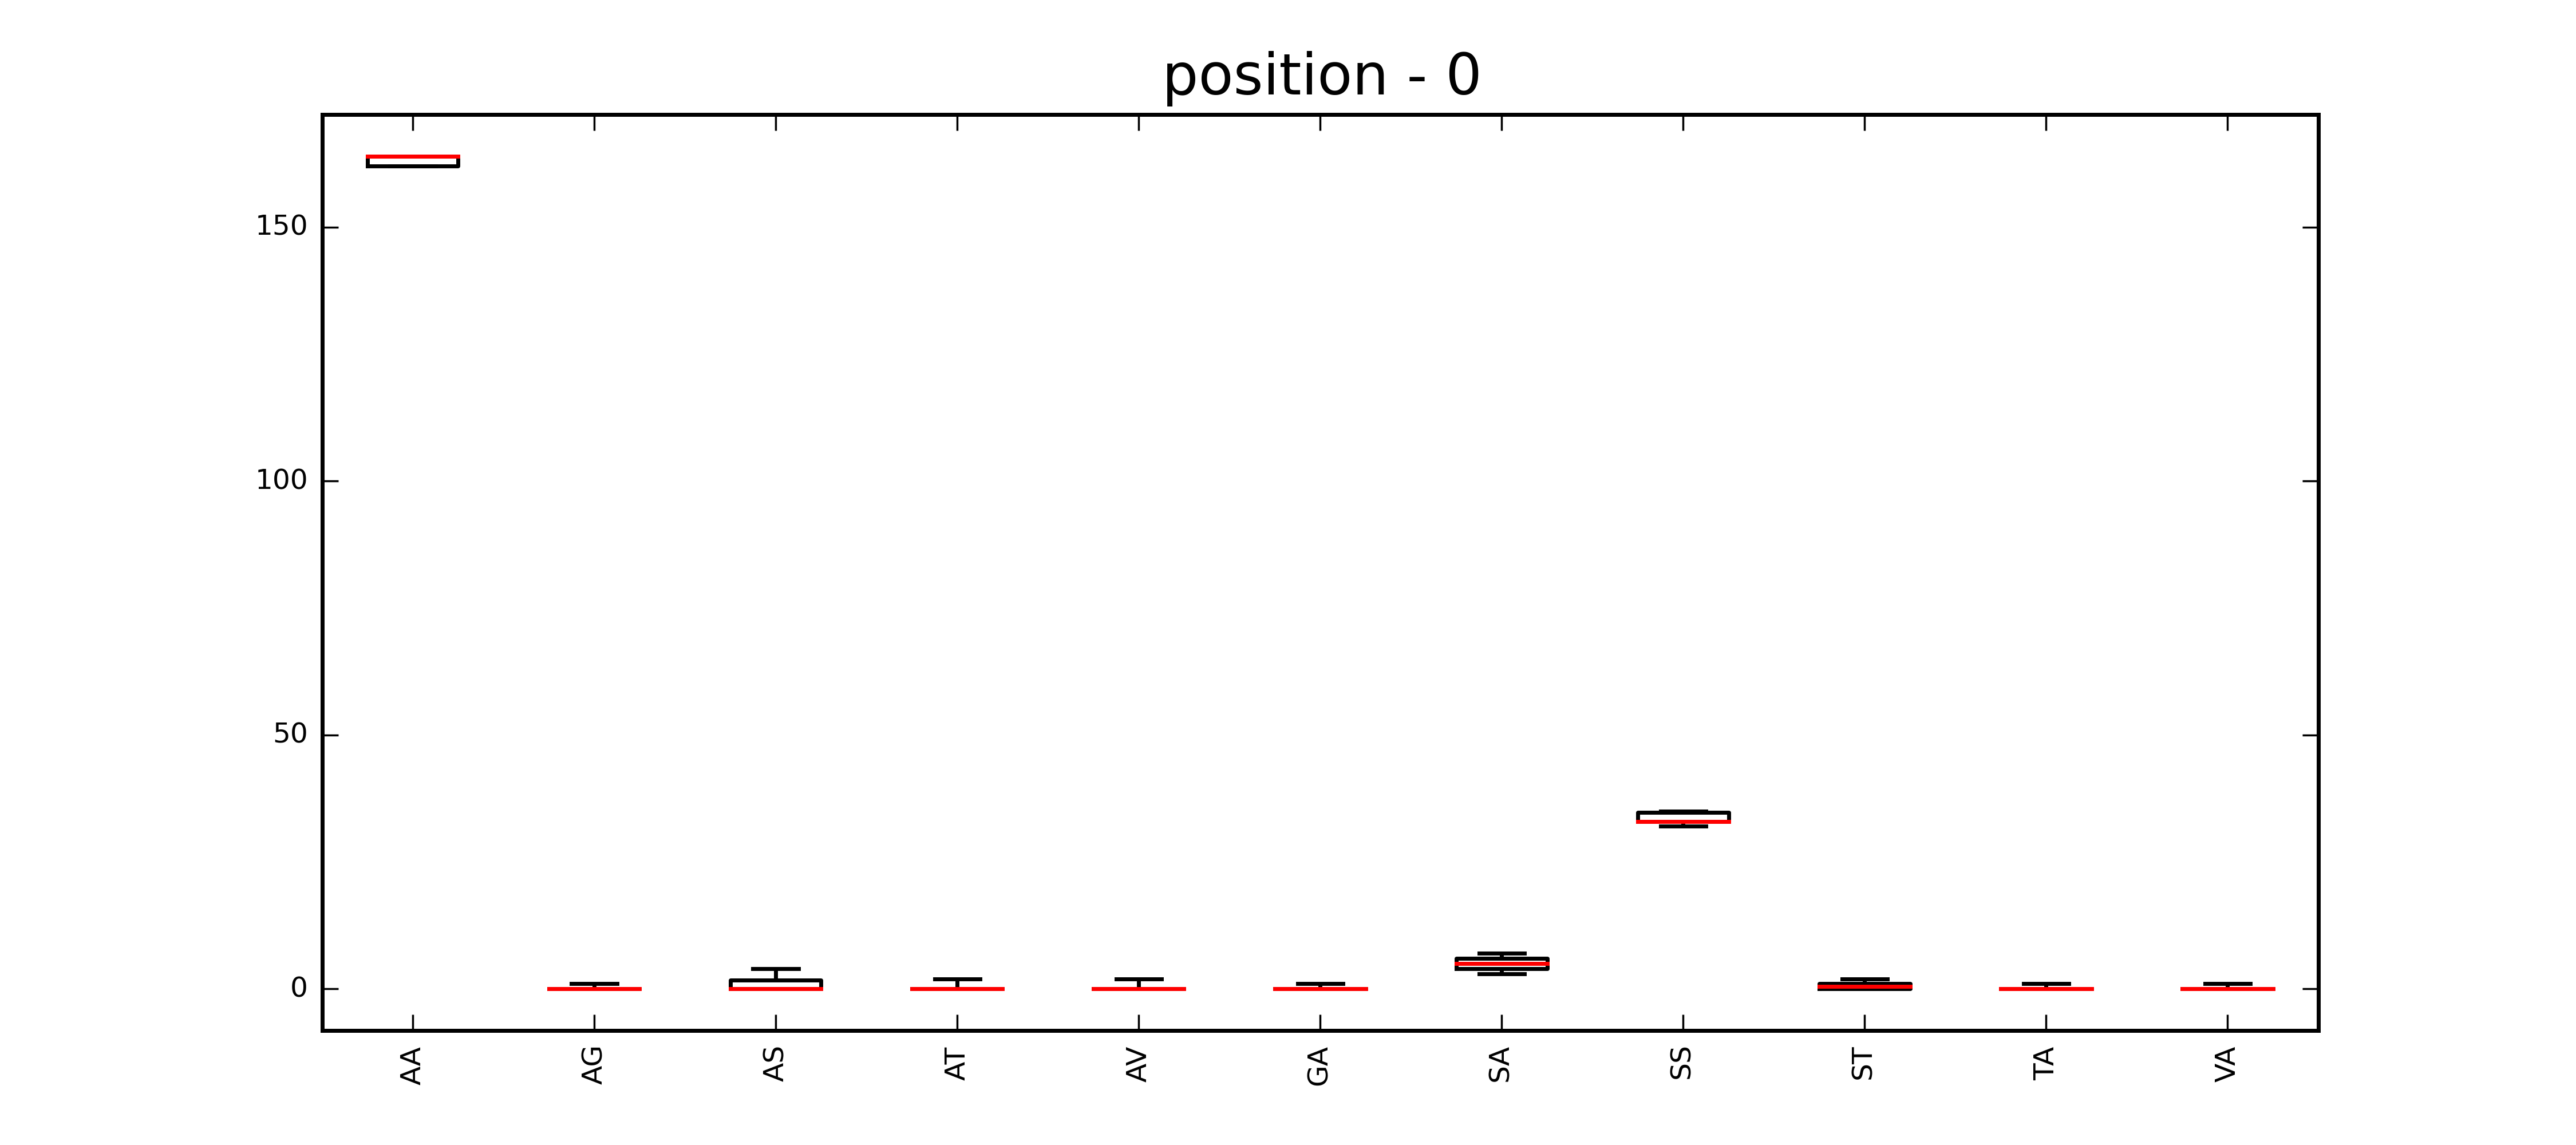

In [38]:
from IPython.display import Image
dataDir = None
for ddir in [os.path.join("..","data","herve-vertebrates"),\
             os.path.join("/","media","ganda","mojo","phylogenetic-models","herve-vertebrates")]:
    if os.path.isdir(ddir):
        dataDir = ddir

split = "SPLIT1"
position = "0"
treeList = get_trees(split,position,dataDir)
countMatrix = np.zeros((len(treeList),len(TRANSITIONS)),)
t = 0
for t,pbTree in enumerate(treeList):
    fixedTree,treeSummary = fix_tree(pbTree)
    tlist = []
    for item in treeSummary.itervalues():
        tlist.extend(item['pairs'])
    counts = transitions_to_counts(tlist)
    countMatrix[t,:] = counts

figName1 = os.path.join("figures","lda-bplot-check.png")
profile_box_plot(countMatrix,figName1,figTitle='position - %s'%position)
Image(filename=figName1)

Where to go
-------------------

  * whole tree summary
  * species specific tree summary
  * incorporate gene boundries
  * parameter search to optimize num. of words per topic and num. topics
  * add distance calculator (KL-divergence) to get distance between any two topic distributions
  * port to MALLET (U. Mass) or another tuned library


## References

  * Blei, D. Probabilistic topic models Communications of the ACM, 2012, 55, 77-84
  * Blei, D. M.; Ng, A. Y. & Jordan, M. I. Latent Dirichlet Allocation Journal of Machine Learning Research, 2003, 3, 993-1022
  * Ferguson, T. S. A Bayesian Analysis of Some Nonparametric Problems The Annals of Statistics, 1973, 1, 209-230 
  * Huelsenbeck, J. P.; Jain, S.; Frost, S. W. D. & Pond, S. L. K. A Dirichlet process model for detecting positive selection in protein-coding DNA sequences PNAS, 2006, 103, 6263-8
  * Robinson, D. M.; Jones, D. T.; Kishino, H.; Goldman, N. & Thorne, J. L. Protein evolution with dependence among codons due to tertiary structure Mol. Biol. Evol., 2003, 20, 1692-1704
  * Rodrigue, N.; Kleinman, C. L.; Philippe, H. & Lartillot, N. Computational methods for evaluating phylogenetic models of coding sequence evolution with dependence between codons. Molecular biology and evolution, 2009, 26, 1663-76